In [4]:
import cv2 as cv
import numpy as np
import random
from PIL import Image
from image_utils import *
from blank import *
%load_ext autoreload
%autoreload 2

In [102]:
def parse_cfg(cfg_path):
    
    # only supports distributon configs for now
    
    cfg = {}
    
    with open(cfg_path) as f:
        for line in f:          
            line = line.strip()
            if line[0] == '#':
                continue
            else:
                key,value = line.split('=')
                
                key = key.strip()
                value = float(value.strip())
                
                cfg[key] = value
                
                
    return cfg  

In [103]:
def get_img_data(directory_path):
    
    path_slash = '\\' if os.name == 'nt' else '/'
    
    if directory_path[-1] != path_slash:
        directory_path += path_slash
        
    img_names = []
    imgs = []
    
    for file_name in glob.glob(directory_path + '*'):
        
        if '.cfg' in file_name:
            cfg = parse_cfg(file_name)
            cfg = {k.replace('.npy', '') : v for k,v in cfg.items()} # removing potential .npy extension from key(name)
        else:
            cur_img = np.load(file_name)
            imgs.append(cur_img)
            
            cur_img_name = file_name.split(path_slash)[-1]
            cur_img_name = cur_img_name.split('.')[0]         
            img_names.append(cur_img_name)
            
    
    distribution = []
    
    for img_name in img_names:
        distribution.append(cfg[img_name])
    
    return img_names, imgs, distribution

In [66]:
st = np.load('nums/two.npy')

In [67]:
st = adaptive_thresh(st)

error: OpenCV(3.4.1) C:\bld\opencv_1520732670222\work\opencv-3.4.1\modules\imgproc\src\filter.cpp:288: error: (-215) wholeSize.width > 0 && wholeSize.height > 0 in function cv::FilterEngine::proceed


In [ ]:
def display(img):
    return Image.fromarray(img)

In [68]:
display(st)

SystemError: tile cannot extend outside image

<PIL.Image.Image image mode=L size=0x34 at 0x21A8B280630>

In [69]:
a = get_blanks('blanks')[2]
a.img = adaptive_thresh(a.img)

cnt = 0

while cnt < 20:
    row = random.randint(a.min_row, a.max_row)
    col = random.randint(a.min_col, a.max_col)
    
    while not a.place_object(st, (row, col)):
        row = random.randint(a.min_row, a.max_row)
        col = random.randint(a.min_col, a.max_col)
        continue
    
    cnt += 1


ValueError: zero-size array to reduction operation maximum which has no identity

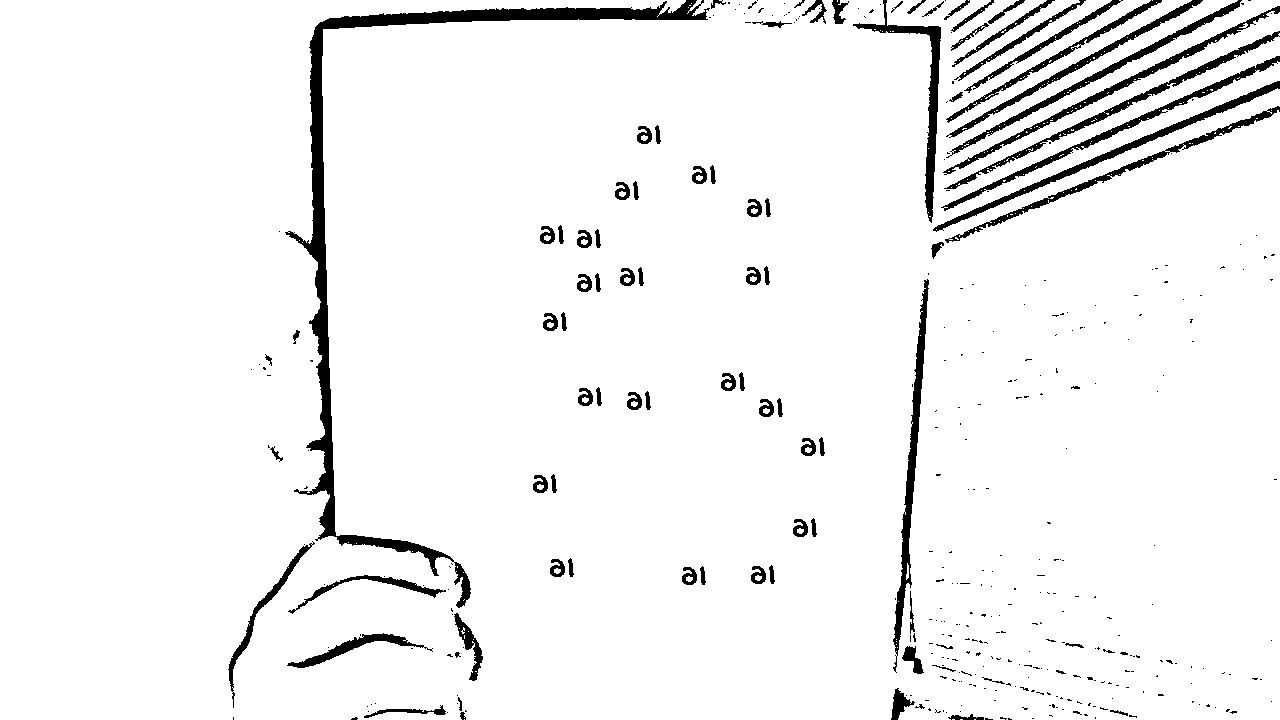

In [65]:
display(a.img)